In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.tensorboard as tb
import tqdm
from torchsummary import summary
import onnx
import onnxruntime
torch.backends.cudnn.benchmark = True


In [28]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010]),
])

In [29]:
ds_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
ds_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
(3072,)


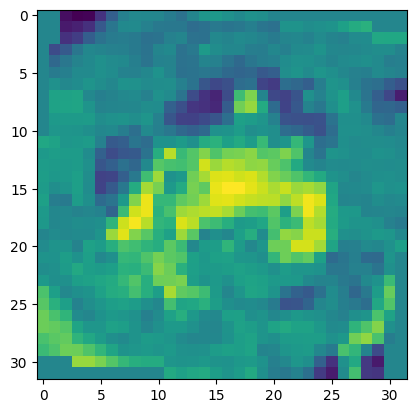

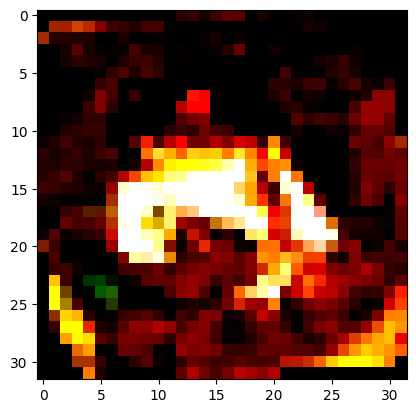

In [30]:
print(ds_train[0][0].shape)
plt.imshow(ds_train[0][0][0])
plt.figure()
plt.imshow(ds_train[0][0].permute(1,2,0))
print(np.array(ds_train[0][0]).flatten().shape)
np.save('test.npy', np.array(ds_train[0][0]).flatten())

In [31]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=4, drop_last = True, pin_memory=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=4, drop_last = True, pin_memory=True)

In [32]:
class Conv_bloc(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1)
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1, groups=in_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 1)
        self.act = nn.ELU()

    # def forward(self, x):
    #     input_ = x
    #     x = self.conv1(x)
    #     x = self.act(x)
    #     x = self.conv(x)
    #     x = self.act(x)
    #     x = x+input_
    #     x = self.conv2(x)
    #     x = self.act(x)
    #     return x
    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        return x

class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.ln1 = nn.LayerNorm((32,32,32)) #
        self.conv2 = Conv_bloc(32, 64)
        self.dp = nn.Dropout2d(0.1)
        self.mpool = nn.MaxPool2d(2)
        self.ln2 = nn.LayerNorm((64, 16, 16)) #
        self.conv3 = Conv_bloc(64, 128)
        self.mpool2 = nn.MaxPool2d(2)
        self.ln3 = nn.LayerNorm((128,8,8)) #
        self.conv4 = Conv_bloc(128, 256)
        self.mpool3 = nn.MaxPool2d(2)
        #self.ln4 = nn.LayerNorm((128, 4, 4)) #
        self.conv5 = Conv_bloc(256, 128)
        self.mpool4 = nn.MaxPool2d(2)
        #self.ln5 = nn.LayerNorm((128, 2, 2)) #
        self.conv6 = Conv_bloc(128, 64)
        self.mpool5 = nn.MaxPool2d(2)

        self.temp = None

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(512, 256) #
        self.fc2 = nn.Linear(64, 10)
        self.act = nn.ELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.ln1(x) #
        x = self.act(x)
        x = self.conv2(x)
        x = self.mpool(x)
        x = self.dp(x)
        x = self.ln2(x) #
        x = self.conv3(x)
        x = self.dp(x)
        x = self.mpool2(x)
        x = self.dp(x)
        x = self.ln3(x) #
        x = self.conv4(x)
        x = self.mpool3(x)
        x = self.dp(x)
        #x = self.ln4(x) #
        x = self.conv5(x)
        x = self.mpool4(x)
        x = self.dp(x)
        #x = self.ln5(x) #
        x = self.conv6(x)
        x = self.mpool5(x)
        x = self.dp(x)
        # self.temp = x.detach().clone()
        x = self.flat(x)
        #x = self.fc1(x)
        #x = self.act(x)
        x = self.fc2(x)
        #add softmax
        #x = nn.functional.softmax(x, dim=1)
        return x

    def display(self):
        temp = torch.reshape(self.temp, (1, 32, 32))
        print(temp.shape)
        plt.imshow(temp.permute(1,2,0))


        

In [33]:
net = MyCNN()
dummy_input = torch.randn(1, 3, 32, 32)
out = net(dummy_input)

In [34]:
# temp = net.temp
# print(temp.shape)
#net.display()
summary(net, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         LayerNorm-2           [-1, 32, 32, 32]          65,536
               ELU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             320
               ELU-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]           2,112
               ELU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]           4,160
         Conv_bloc-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
        Dropout2d-11           [-1, 64, 16, 16]               0
        LayerNorm-12           [-1, 64, 16, 16]          32,768
           Conv2d-13           [-1, 64, 16, 16]             640
              ELU-14           [-1, 64,

In [35]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
n_epochs = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(dl_train), epochs=n_epochs)


writer = tb.SummaryWriter()
writer.add_graph(net, torch.randn(1, 3, 32, 32))
net = net.to("mps")
best_loss = np.inf
for e in range(n_epochs):
    net.train()
    total_accuracy = 0
    total_loss = 0
    for X, y in tqdm.tqdm(dl_train):
        X = X.to("mps")
        y = y.to("mps")
        pred = net(X)
        loss = loss_fn(pred, y)
        total_accuracy+= (pred.argmax(1)==y).sum().cpu().detach()
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    accuracy = total_accuracy /len(dl_train.dataset)
    print(f'TRAIN Accuracy: {accuracy}, Loss: {total_loss}, epoch: {e+1}')

    with torch.no_grad():
        net.eval()
        total_accuracy = 0
        total_loss = 0
        for X, y in tqdm.tqdm(dl_test):
            X = X.to("mps")
            y = y.to("mps")
            pred = net(X)
            loss = loss_fn(pred, y)
            total_accuracy+= (pred.argmax(1)==y).sum().cpu().detach()
            total_loss += loss.item()

        accuracy = total_accuracy /len(dl_test.dataset)
        if best_loss > total_loss:
            best_loss = total_loss
            torch.save(net.state_dict(), "best_model_mps.pth")
            print("Model saved")
        print(f'TEST Accuracy: {accuracy}, Loss: {total_loss}, epoch: {e+1}')

net.load_state_dict(torch.load("best_model_mps.pth"))




100%|██████████| 781/781 [01:02<00:00, 12.58it/s]


TRAIN Accuracy: 0.24500000476837158, Loss: 1553.7267482280731, epoch: 1


100%|██████████| 156/156 [00:26<00:00,  5.81it/s]


Model saved
TEST Accuracy: 0.42179998755455017, Loss: 239.3330569267273, epoch: 1


100%|██████████| 781/781 [00:57<00:00, 13.68it/s]


TRAIN Accuracy: 0.47775998711586, Loss: 1108.598118185997, epoch: 2


100%|██████████| 156/156 [00:26<00:00,  5.79it/s]


Model saved
TEST Accuracy: 0.5720999836921692, Loss: 183.498066842556, epoch: 2


100%|██████████| 781/781 [00:55<00:00, 14.06it/s]


TRAIN Accuracy: 0.5701599717140198, Loss: 924.1349996328354, epoch: 3


100%|██████████| 156/156 [00:26<00:00,  5.92it/s]


Model saved
TEST Accuracy: 0.6341000199317932, Loss: 157.43407851457596, epoch: 3


100%|██████████| 781/781 [00:56<00:00, 13.88it/s]


TRAIN Accuracy: 0.6232200264930725, Loss: 816.2025579214096, epoch: 4


100%|██████████| 156/156 [00:26<00:00,  5.82it/s]


Model saved
TEST Accuracy: 0.6676999926567078, Loss: 143.44434440135956, epoch: 4


100%|██████████| 781/781 [00:58<00:00, 13.37it/s]


TRAIN Accuracy: 0.6514000296592712, Loss: 760.2757424116135, epoch: 5


100%|██████████| 156/156 [00:26<00:00,  5.87it/s]

Model saved
TEST Accuracy: 0.6748999953269958, Loss: 140.61465966701508, epoch: 5


<All keys matched successfully>

In [37]:
class_names = ['airplane','automobile','bird','cat','deer',
                'dog','frog','horse','ship','truck']
                
net = MyCNN()
dummy_input = torch.randn(1, 3, 32, 32)
net.load_state_dict(torch.load("best_model_mps.pth"))
dummy_input = dummy_input.to("cpu")  
net = net.to("cpu")  

torch.onnx.export(net, dummy_input, "model.onnx", verbose=False, input_names= ["input"], output_names= ["output"], opset_version=13, dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}) #ONNX conversion
#torch.save(net.state_dict(), "model.pth") #Pytorch weights saving
writer.close()
onnx_model = onnx.load("model.onnx")
print(onnx.checker.check_model(onnx_model))


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

None


In [38]:
#evaluate onnx model
ort_session = onnxruntime.InferenceSession("model.onnx")
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

total_accuracy = 0
total_loss = 0
for X, y in tqdm.tqdm(dl_test):
    #unbatch
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(X)}
    
    ort_outs = ort_session.run(None, ort_inputs)
    pred = torch.from_numpy(ort_outs[0])
    total_accuracy+= (pred.argmax(1)==y).sum().cpu().detach()
    total_loss += loss_fn(pred, y).item()

accuracy = total_accuracy /len(dl_test.dataset)
print(f'TEST Accuracy: {accuracy}, Loss: {total_loss}')


100%|██████████| 156/156 [00:31<00:00,  4.96it/s]

TEST Accuracy: 0.6748999953269958, Loss: 140.61466526985168
